**These code cells were run on google colab with GPU support.**

In [1]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


**Fetching the data**

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mnist = fetch_openml("mnist_784", version=1)
print(mnist.keys())


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])


**Plotting one example of each class**

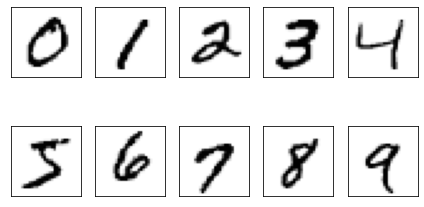

In [3]:
**Out of 70k examples, 10k will be used for test set, and remaining will be used for training and validation.**X = mnist["data"]
Y = mnist["target"]
Y = Y.astype(int)
X=(X/255 - 0.5)*2

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    for x, y in zip(X, Y):
        if y==i:
            img=np.array(x).reshape((28,28))
            ax[i].imshow(img, cmap="Greys")
            break
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout()
plt.show()

**Out of 70k examples, 10k will be used for test set, and remaining will be used for training and validation.**

In [4]:
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, val_index in split.split(X_train,Y_train):
    X_train_strat = X_train[train_index, :]
    Y_train_strat = Y_train[train_index]
    X_val_strat = X_train[val_index, :]
    Y_val_strat = Y_train[val_index]

In [6]:
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix


**Extending and overriding methods for our own dataset**

In [7]:

class mnist_dataset(data.Dataset):
    def label_transformer(self, labels):
        return labels

    def __init__(self, input_data, labels):
        input_data = input_data.reshape((len(input_data),1,28,28))
        self.feats = input_data
        self.labels = self.label_transformer(labels)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        x = self.feats[index]
        y = self.labels[index]
        return x,y


**Creating dataloader for each of the train, validation, test dataset.**

In [8]:
class hyperparam:
    bs = 100
    lr = 0.05
    num_epochs = 50

params = {
    "batch_size": hyperparam.bs,
    "shuffle": True,
    "num_workers": 2,
    "drop_last": False,
    "pin_memory": True
}

train_set = mnist_dataset(X_train_strat, Y_train_strat)
val_set = mnist_dataset(X_val_strat, Y_val_strat)
test_set = mnist_dataset(X_test, Y_test)

training_gen = data.DataLoader(train_set, **params)
val_gen = data.DataLoader(val_set, **params)
test_gen = data.DataLoader(test_set, **params)

**Created a DNN with 2 layers of CNN with 12 filters each and adding two fully connected layers of 100 and 10 neurons respectively.
Used Relu activation function, with initial learning rate = 0.05 with glorot initialization.
We have added a dropout layer after each hidden layer in the network. The dropout value is taken in the constructor and remains the same for all the dropout layers in the model.**

In [9]:
from torch.nn import Conv2d, Linear
from torch import flatten

class dropout_cnn(nn.Module):
    
    def glorot_initialize(self, layers):
        
        for layer in layers:
            torch.nn.init.xavier_normal_(layer.weight)
            torch.nn.init.zeros_(layer.bias)
    
    def __init__(self, dropout_val):
        super(dropout_cnn, self).__init__()
        self.conv1 = Conv2d(1,12,kernel_size=(3,3), padding = 1)
        self.conv2 = Conv2d(12,12,kernel_size=(3,3), padding = 1)
        self.fc1 = Linear(588, 100)
        self.fc2 = Linear(100, 10)
        
        self.dropout = nn.Dropout(dropout_val)

        self.glorot_initialize([self.conv1, self.conv2, self.fc1, self.fc2])
        
        
    def forward(self, sig):
        sig = Func.max_pool2d(Func.relu(self.conv1(sig)), (2, 2))
        sig = self.dropout(sig)
        sig = Func.max_pool2d(Func.relu(self.conv2(sig)), (2, 2))
        sig = self.dropout(sig)
        sig = sig.view(-1, 12*7*7)
        sig = Func.relu(self.fc1(sig))
        sig = self.dropout(sig)
        sig = self.fc2(sig)
        return sig
        # return Func.softmax(sig, dim = 1)


**Model is trained for 50 epochs, after each epochs, printing the validation accuracy. and resulting learning rate after adjusting learning rate by 10% each 10 epochs
Also using early stopping mechanism, which stops the learning if the validation accuracy starts dropping for a consecutive 5 cycles. This is done to prevent overfitting.**

**We have created three seperate models, each using different dropout value. We will train each of these for 50 epochs with early stopping. We will record how these perform.**

In [10]:
cnn_models = [dropout_cnn(0.25).to(device), dropout_cnn(0.5).to(device), dropout_cnn(0.75).to(device)]

In [11]:
from tqdm import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import StepLR

tr_avg_loss_list = {0: [], 1:[], 2:[]}
tr_accuracy_list = {0: [], 1:[], 2:[]}
val_avg_loss_list = {0: [], 1:[], 2:[]}
val_accuracy_list = {0: [], 1:[], 2:[]}

print(datetime.now())

for model_num, cnn_model in enumerate(cnn_models):

    optimizer = torch.optim.SGD(cnn_model.parameters(), lr = hyperparam.lr, momentum=0.9) 
    scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
    loss = nn.CrossEntropyLoss()

    for epoch in range(hyperparam.num_epochs):
        print("Epoch:" + str(epoch) + " dropout: " + str((model_num+1)*0.25))
        tr_num_correct = 0
        tr_num_samples = 0
        tr_total_loss = 0
        val_num_correct = 0
        val_num_samples = 0
        val_total_loss = 0
        
        print("Learning rate: " + str(optimizer.param_groups[0]['lr']))

        cnn_model.train(True)
        with torch.set_grad_enabled(True):
            for ind, (local_batch, local_labels) in enumerate(training_gen):
                
                optimizer.zero_grad()
                local_batch = local_batch
                local_labels = local_labels
                local_batch, local_labels = Variable(local_batch).float(), Variable(local_labels)
                local_batch = local_batch.to(device)
                local_labels = local_labels.to(device)
                out1 = cnn_model(local_batch)
                
                ploss = loss(out1, local_labels.long())
                tr_total_loss += ploss * hyperparam.bs
                ploss.backward()
                optimizer.step()
                sel_class = torch.argmax(out1, dim=1)
                tr_num_correct += sel_class.eq(local_labels).sum().item()
                tr_num_samples += hyperparam.bs
                    
                                    
            tr_avg_loss = tr_total_loss / len(training_gen.dataset)
            tr_avg_loss_list[model_num].append(tr_avg_loss)
            tr_accuracy = tr_num_correct / len(training_gen.dataset)
            tr_accuracy_list[model_num].append(tr_accuracy)
        
        with torch.set_grad_enabled(False):
            cnn_model.eval()
            for local_batch, local_labels in val_gen:
                local_batch = local_batch.float()
                local_labels = local_labels.float()
                local_batch, local_labels = Variable(local_batch), Variable(local_labels)
                local_batch = local_batch.to(device)
                local_labels = local_labels.to(device)
                out1 = cnn_model(local_batch)
                ploss = loss(out1, local_labels.long())
                val_total_loss += ploss * hyperparam.bs
                sel_class = torch.argmax(out1, dim=1)
                val_num_correct += sel_class.eq(local_labels).sum().item()
                val_num_samples += local_labels.size(0)

            val_avg_loss = val_total_loss / len(val_gen.dataset)
            val_avg_loss_list[model_num].append(val_avg_loss)
            val_accuracy = val_num_correct / len(val_gen.dataset)
            print("Validation accuracy: " + str(val_accuracy))
            val_accuracy_list[model_num].append(val_accuracy)
            scheduler.step()

            if epoch > 10:
                if sum([val_accuracy_list[model_num][i] < val_accuracy_list[model_num][i-1] for i in range(epoch-5, epoch)]) == 5:
                    break

2021-04-11 08:04:37.031426
Epoch:0 dropout: 0.25
Learning rate: 0.05
Validation accuracy: 0.9748333333333333
Epoch:1 dropout: 0.25
Learning rate: 0.05
Validation accuracy: 0.9815
Epoch:2 dropout: 0.25
Learning rate: 0.05
Validation accuracy: 0.9846666666666667
Epoch:3 dropout: 0.25
Learning rate: 0.05
Validation accuracy: 0.9858333333333333
Epoch:4 dropout: 0.25
Learning rate: 0.05
Validation accuracy: 0.9865
Epoch:5 dropout: 0.25
Learning rate: 0.05
Validation accuracy: 0.985
Epoch:6 dropout: 0.25
Learning rate: 0.05
Validation accuracy: 0.9848333333333333
Epoch:7 dropout: 0.25
Learning rate: 0.05
Validation accuracy: 0.9868333333333333
Epoch:8 dropout: 0.25
Learning rate: 0.05
Validation accuracy: 0.9866666666666667
Epoch:9 dropout: 0.25
Learning rate: 0.05
Validation accuracy: 0.9858333333333333
Epoch:10 dropout: 0.25
Learning rate: 0.045000000000000005
Validation accuracy: 0.9865
Epoch:11 dropout: 0.25
Learning rate: 0.045000000000000005
Validation accuracy: 0.9866666666666667
Epoc

**Plotting learning curves for validation and train dataset**

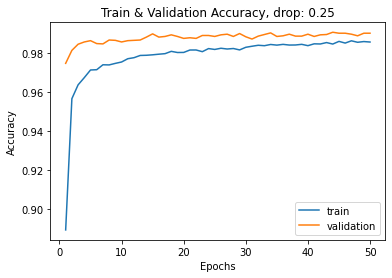

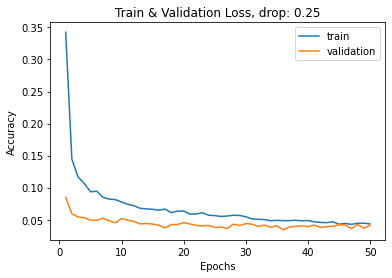

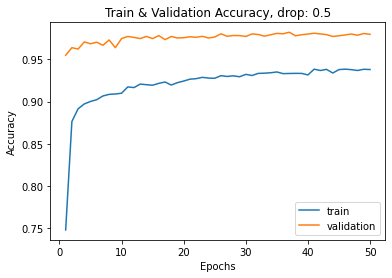

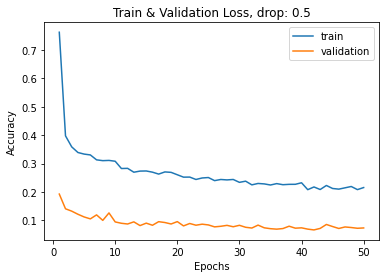

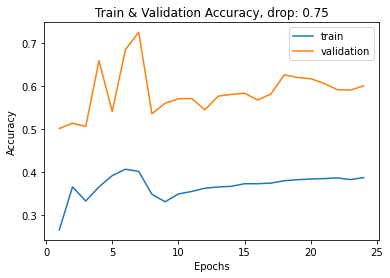

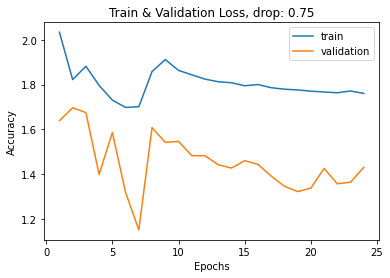

In [12]:
def plot_x_y_vals(x_vals, y_vals, x_label, y_label, label, line_titles):
    for i in range(len(x_vals)):
        plt.plot(x_vals[i], y_vals[i], label=line_titles[i])
    plt.title(label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

for i in tr_accuracy_list:
    epocs = [i+1 for i in range(len(tr_accuracy_list[i]))]
    plot_x_y_vals([epocs, epocs], [tr_accuracy_list[i], val_accuracy_list[i]], "Epochs", "Accuracy", "Train & Validation Accuracy, drop: " + str((i+1)*0.25), ["train", "validation"])
    plot_x_y_vals([epocs, epocs], [tr_avg_loss_list[i], val_avg_loss_list[i]], "Epochs", "Accuracy", "Train & Validation Loss, drop: " + str((i+1)*0.25), ["train", "validation"])

**Overfit or Underfit? Why is validation accuracy higher than training accuracy?**

Surprisingly, we see that validation accuracy is higher than training accuracy. This is because of the dropout layer. During training phase, the dropout layers set some of the values to zero, while in evaluation phase, that does not happen. That is why during the validation phase, our model performs better.

**For dropout = 0.25**, we see that model has done really well.Validation accuracy continues to increase while validation loss continues to decrease. While dropout layer makes sure that the model doesnt overfit. With dropout = 0.25, we seem to have achieved that balance where the plot is indicating that it neither overfits nor underfits. As the validation and training are converging in the plot. As can be seen in the plot, the validation accuracy stands around ~98%

**For Dropout = 0.5**, we see that model doesnt perform as good as with dropout = 0.25, and the accuracy is around ~98%, This could be very slightly better, and is a sign of **slightly underfitting.** This means that our model is too simplistic and only views at most outlining features of the image, while ignoring complicated features of the image. This is because of high dropout value = 0.5, which seem to have removed finer details from the image, leaving the model to only work on most outlining features of the image.

**for Dropout = 0.75**, we see that model gets an accuracy around 60%. Definitlely not as good, and is **underfitting**. Primarily because the dropout layers have removed most of the relevant information, making the model to only work on simplified data. Due to which model makes very generic assumptions about the images.

**Checking the accuracy of test set**

In [13]:
total_accurate = [0,0,0]
total_values = [0,0,0]
errors={0:{i:{j:0 for j in range(10)} for i in range(10)}, 1:{i:{j:0 for j in range(10)} for i in range(10)}, 2:{i:{j:0 for j in range(10)} for i in range(10)}}
incorrect_samples = {0:[], 1:[], 2:[]}
correct_samples = {0:[], 1:[], 2:[]}

def calculate_class_wise_errors(local_labels, sel_class, local_batch, model_num):
    true_labels = local_labels[sel_class.not_equal(local_labels)]
    predicted = sel_class[sel_class.not_equal(local_labels)]
    for (i, t), (i,p) in zip(enumerate(true_labels), enumerate(predicted)):
        errors[model_num][t.item()][p.item()] += 1
    
    true_labels = local_labels[sel_class.eq(local_labels)]
    predicted = sel_class[sel_class.eq(local_labels)]
    for (i, t), (i,p) in zip(enumerate(true_labels), enumerate(predicted)):
        errors[model_num][t.item()][p.item()] += 1

    if len(incorrect_samples[model_num]) < 10:
        samples = local_batch[sel_class.not_equal(local_labels)]
        predicted = sel_class[sel_class.not_equal(local_labels)]
        true_labels = local_labels[sel_class.not_equal(local_labels)]
        for (i,s), (i,p), (i, t) in zip(enumerate(samples), enumerate(predicted), enumerate(true_labels)):
            incorrect_samples[model_num].append((s.cpu().numpy(), p.cpu().numpy(), t.cpu().numpy()))

    if len(correct_samples[model_num]) < 10:
        samples = local_batch[sel_class.eq(local_labels)]
        predicted = sel_class[sel_class.eq(local_labels)]
        true_labels = local_labels[sel_class.eq(local_labels)]
        for (i,s), (i,p), (i, t) in zip(enumerate(samples), enumerate(predicted), enumerate(true_labels)):
            correct_samples[model_num].append((s.cpu().numpy(), p.cpu().numpy(), t.cpu().numpy()))

for model_num, cnn_model in enumerate(cnn_models):
    with torch.set_grad_enabled(False):
        cnn_model.eval()
        for local_batch, local_labels in test_gen:
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)
            out1 = cnn_model(local_batch)
            ploss = loss(out1, local_labels.long())
            sel_class = torch.argmax(out1, dim=1)
            calculate_class_wise_errors(local_labels, sel_class, local_batch, model_num)
            total_accurate[model_num] += sel_class.eq(local_labels).sum().item()
            total_values[model_num] += local_labels.size(0)

    

In [14]:
print("Predicted " + str(total_accurate) +" correctly out of " + str(total_values) + "for respective drops: " + str([0.25,0.5,0.75]))


Predicted [9918, 9844, 6052] correctly out of [10000, 10000, 10000]for respective drops: [0.25, 0.5, 0.75]


As can be seen through test accuracies, the dropout = 0.25 makes the best assumption about the images without under of overfitting. The accuracy is ever so slightly higher than that baseline model.

For dropout = 0.5, the model still performs well. However the accuracy is ever so slightly below the baseline. We can say that it **slightly underfits**

For dropout = 0.75, the model performs the worse and **greatly underfits** the test data well.

Below we are plotting the heatmap, where y-axis represents the actual label and x-axis represents the predicted labels. Pleaase mind that all the diagonal elements have been set to zero. So the heatmap only represents the incorrectly classified label counts.

For example row = 4, col = 3 represents the count of images, which were 4, but were actually classified as 3. And the cell (4,4) is left empty, although it should ideally contain count of all the correctly classified images of 4. As this heatmap is generated only to see if there is any pair that is mistaken a lot in the classification OR if there is any bias in our model for any label.

We have plotted the heatmap for all three models.

Dropout rate of 0.25


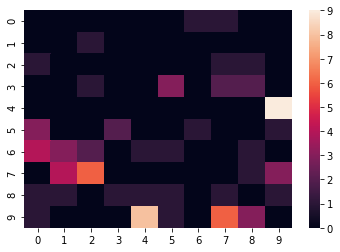

Dropout rate of 0.5


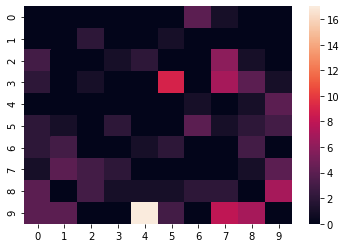

Dropout rate of 0.75


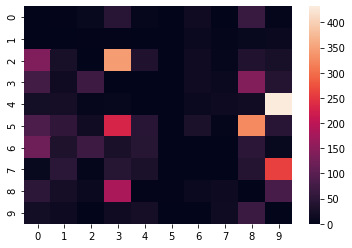

In [15]:
import seaborn as sns
class_acc = np.zeros((3,10,10))
for d in range(3):
    for i in range(10):
        for j in range(10):
            if i!=j:
                class_acc[d,i,j] = errors[d][i][j]
            else:
                class_acc[d,i,j] = 0
    print("Dropout rate of " + str((d+1) * 0.25))
    sns.heatmap(class_acc[d])
    plt.show()

**Plotting few incorrectly classified images by our model. We see that these images are ambiguous and little bit hard to interpret or blurry. Each image contains the true value - predicted value pair on top of it.**

Incorrectly classified samples. (True and predicted values)


Dropout rate:0.25


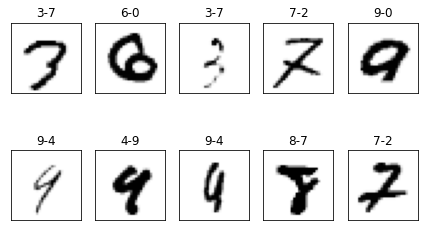



Dropout rate:0.5


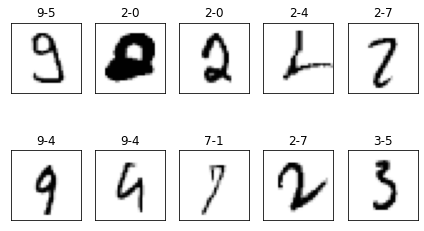



Dropout rate:0.75


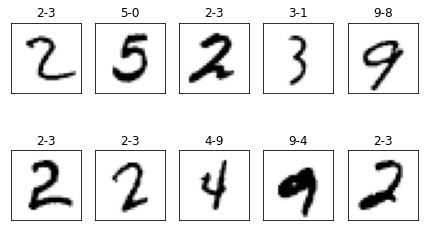

In [16]:
print("Incorrectly classified samples. (True and predicted values)")

for d in range(3):
    print("\n\nDropout rate:" + str(d*0.25 + 0.25))
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    for i in range(10):
        img=np.array(incorrect_samples[d][i][0]).reshape(28,28)
        ax[i].imshow(img, cmap="Greys")
        ax[i].title.set_text(str(int(incorrect_samples[d][i][2])) + "-" + str(incorrect_samples[d][i][1]))
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    plt.tight_layout()
    plt.show()


**Plotting few correctly classified images by our model.**

Correctly classified samples. (true and predicted values)


Dropout rate:0.25


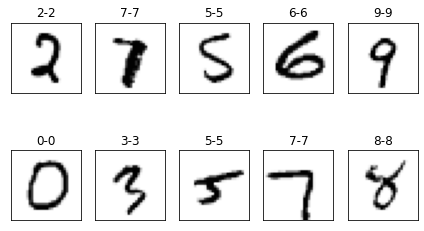



Dropout rate:0.5


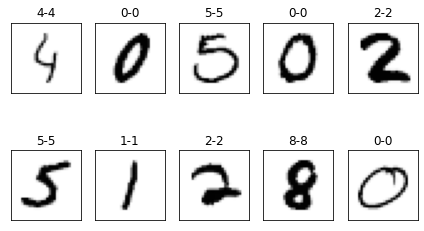



Dropout rate:0.75


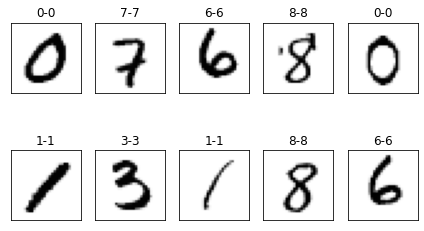

In [17]:

print("Correctly classified samples. (true and predicted values)")
for d in range(3):
    print("\n\nDropout rate:" + str(d*0.25 + 0.25))
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    for i in range(10):
        img=np.array(correct_samples[d][i][0]).reshape(28,28)
        ax[i].imshow(img, cmap="Greys")
        ax[i].title.set_text(str(int(correct_samples[d][i][2])) + "-" + str(correct_samples[d][i][1]))
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    plt.tight_layout()
    plt.show()



**Plotting below confusion matrix for each class. By each class, we mean all the correct prediction fot that class = true positive. all the images of a class, that were incorrectly classfied as false negative. All the images, not of that class, but classified as of that class as false positive. And all the images that were not of a class and were also classified as not belonging to that class as true negative.**

**We are plotting confusion matrix for all three cases.**

In [18]:
import pandas as pd
# Confusion matrix
confusion_arr = np.zeros((3, 10, 4))
confusion_dfs = []
for d in range(3):
    for i in range(10):
        confusion_arr[d][i][0] = errors[d][i][i] # tp
        for j in range(10):
            if i!=j:
                confusion_arr[d][i][1]+=errors[d][j][i] # fp
        for j in range(10):
            if i!=j:
                confusion_arr[d][i][2]+= errors[d][i][j] # fn
        confusion_arr[d][i][3] = total_values[d] - sum(confusion_arr[d][i][:3]) # tn
    
    confusion_dfs.append(pd.DataFrame(confusion_arr[d], columns=["tp", "fp", "fn", "tn"]))
    confusion_dfs[d]["precision"] = confusion_dfs[d]["tp"] / (confusion_dfs[d]["tp"] + confusion_dfs[d]["fp"])
    confusion_dfs[d]["recall"] = confusion_dfs[d]["tp"] / (confusion_dfs[d]["tp"] + confusion_dfs[d]["fn"])
    confusion_dfs[d]["accuracy"] = (confusion_dfs[d]["tp"] + confusion_dfs[d]["tn"]) / 10000


print("Overall Accuracy:" + str(total_accurate[0]/total_values[0]) + " For dropout:" + str(0.25))
confusion_dfs[0]

Overall Accuracy:0.9918 For dropout:0.25


,tp,fp,fn,tn,precision,recall,accuracy
0,978.0,10.0,2.0,9010.0,0.989879,0.997959,0.9988
1,1134.0,8.0,1.0,8857.0,0.992995,0.999119,0.9991
2,1029.0,10.0,3.0,8958.0,0.990375,0.997093,0.9987
3,1002.0,3.0,8.0,8987.0,0.997015,0.992079,0.9989
4,973.0,10.0,9.0,9008.0,0.989827,0.990835,0.9981
5,885.0,6.0,7.0,9102.0,0.993266,0.992152,0.9987
6,946.0,2.0,12.0,9040.0,0.997890,0.987474,0.9986
7,1014.0,11.0,14.0,8961.0,0.989268,0.986381,0.9975
8,967.0,8.0,7.0,9018.0,0.991795,0.992813,0.9985
9,990.0,14.0,19.0,8977.0,0.986056,0.981169,0.9967


In [19]:
print("Overall Accuracy:" + str(total_accurate[1]/total_values[1]) + " For dropout:" + str(0.5))
confusion_dfs[1]

Overall Accuracy:0.9844 For dropout:0.5


,tp,fp,fn,tn,precision,recall,accuracy
0,975.0,18.0,5.0,9002.0,0.981873,0.994898,0.9977
1,1132.0,12.0,3.0,8853.0,0.989510,0.997357,0.9985
2,1019.0,9.0,13.0,8959.0,0.991245,0.987403,0.9978
3,986.0,6.0,24.0,8984.0,0.993952,0.976238,0.9970
4,976.0,21.0,6.0,8997.0,0.978937,0.993890,0.9973
5,877.0,16.0,15.0,9092.0,0.982083,0.983184,0.9969
6,947.0,11.0,11.0,9031.0,0.988518,0.988518,0.9978
7,1013.0,25.0,15.0,8947.0,0.975915,0.985409,0.9960
8,953.0,19.0,21.0,9007.0,0.980453,0.978439,0.9960
9,966.0,19.0,43.0,8972.0,0.980711,0.957384,0.9938


In [20]:
print("Overall Accuracy:" + str(total_accurate[2]/total_values[2]) + " For dropout:" + str(0.75))
confusion_dfs[2]

Overall Accuracy:0.6052 For dropout:0.75


,tp,fp,fn,tn,precision,recall,accuracy
0,827.0,529.0,153.0,8491.0,0.609882,0.843878,0.9318
1,1092.0,248.0,43.0,8617.0,0.814925,0.962115,0.9709
2,393.0,195.0,639.0,8773.0,0.668367,0.380814,0.9166
3,628.0,908.0,382.0,8082.0,0.408854,0.621782,0.8710
4,444.0,194.0,538.0,8824.0,0.695925,0.452138,0.9268
5,43.0,2.0,849.0,9106.0,0.955556,0.048206,0.9149
6,598.0,120.0,360.0,8922.0,0.832869,0.624217,0.9520
7,588.0,75.0,440.0,8897.0,0.886878,0.571984,0.9485
8,591.0,759.0,383.0,8267.0,0.437778,0.606776,0.8858
9,848.0,918.0,161.0,8073.0,0.480181,0.840436,0.8921


**Here it is to be noted that, true negative has a very high value count, and that is expected. Because it contains almost all the images of other classes, except given class.**

**Because true negative count is high, this results in a very high accuracy for a class. But overall accuracy is not that high. The confusion matrix provided above is only for a class and not overall.**

Overall we see that with dropout layers, the accuracy increased slightly from the baseline model. With dropout layers, we had to make few changes in the fully connected layers of the model.

The model given in the lecture notes had 30 neurons in the first fully connected layer. Because of dropout, this causes issue. Because if the important features are part of a neuron, and dropout shuts that neuron, the subsequent layers will not get that information. Which impacts the training of the network.

However if the number of neurons are higher, that information might leak from some other neuron, that is not shut down by the dropout layer.

With 30 neurons we werent getting good results with dropout. Keeping this in mind, we have changed the architecture of the baseline as well as dropout model both to have 100 neurons instead of only 30 neurons.

Once the number of neurons were increased, the dropout layers started performing really well on the data.

We see that none of our models with dropout, overfit the data. So dropout is a good way to prevent overfitting. It also encourages the model to look for multiple features and not rely on a few specific features.

While the dropout of 0.25 and 0.5 perform great. The dropout with 0.75, classifies with the accuracy of 0.6, which is 6 times better than random guessing.